Reference - https://velog.io/@wilko97/Conditional-GAN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

# Define the path to the saved dataset in Google Drive
save_path = '/content/drive/MyDrive/mnist_dataset.npz'

# Load the dataset from Google Drive
with np.load(save_path) as data:
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']

print("MNIST dataset loaded successfully.")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

MNIST dataset loaded successfully.
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [28]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [27]:
params = {
    'num_classes':10,
    'nz':100,
    'input_size':(1,28,28)
}

In [31]:
class Generator(nn.Module):

    def __init__(self, params):
        super().__init__()
        self.num_classes = params['num_classes']
        self.nz = params['nz'] # 노이즈 수
        self.input_size = params['input_size'] # (1,28,28

        # Noise와 label을 결합하는 용도인 label embedding matrix를 생성
        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

        # Generator
        self.gen = nn.Sequential(
            nn.Linear(self.nz + self.num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,int(np.prod(self.input_size))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # noise와 label의 결합
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), *self.input_size)
        return x

# check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device
x = torch.randn(16,100,device=device) # 노이즈
label = torch.randint(0,10,(16,),device=device) # 레이블
model_gen = Generator(params).to(device)
out_gen = model_gen(x,label) # 가짜 이미지 생성
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


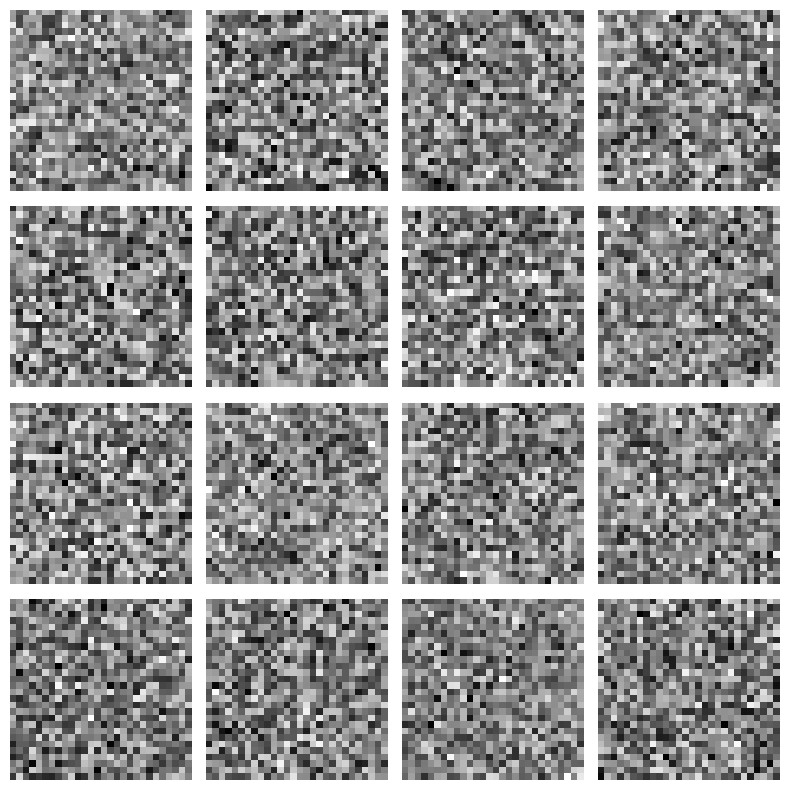

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the tensor to numpy array and remove the channel dimension if it's 1
images = out_gen.cpu().detach().numpy().squeeze()

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    if i < images.shape[0]:
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [33]:
class Discriminator(nn.Module):

     def __init__(self, params):
        super().__init__()
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']
        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)
        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)),512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )

     def forward(self, img, labels):
        # 이미지와 label 결합
        dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)
        x = self.dis(dis_input)
        return x

# check
x = torch.randn(16,1,28,28,device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)

torch.Size([16, 1])


In [34]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

# Train

## Train Dataloader 생성 ( Image, Label ) in MNIST

In [ ]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert numpy arrays to PyTorch tensors
        image = torch.from_numpy(image).float().unsqueeze(0) # Add channel dimension
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Create an instance of the custom dataset
mnist_dataset = MNISTDataset(x_train, y_train)

# Create the DataLoader using the custom dataset
train_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

print(len(train_loader))

## 학습 하이퍼 파라미터 설정

In [35]:
# 손실 함수
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

# optimization
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1,beta2)) # Discrminator
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1,beta2)) # Generator

# 학습 파라미터
nz = params['nz'] # Noise vector initialize
num_epochs = 100

loss_history={'gen':[],
              'dis':[]}


In [40]:
# Train
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_loader:
        ba_si = xb.shape[0] # 배치 크기

        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device) # fake_label

        # Generator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

        # 가짜 이미지 생성
        out_gen = model_gen(noise, gen_label)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()

        # 진짜 이미지 판별
        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen.detach(),gen_label)
        loss_fake = loss_func(out_dis,yb_fake)

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))


Epoch: 1, G_Loss: 0.706029, D_Loss: 0.558677, time: 0.15 min
Epoch: 2, G_Loss: 0.988351, D_Loss: 0.502059, time: 0.29 min
Epoch: 3, G_Loss: 1.070319, D_Loss: 0.400525, time: 0.44 min
Epoch: 4, G_Loss: 1.125647, D_Loss: 0.464218, time: 0.58 min
Epoch: 5, G_Loss: 3.665931, D_Loss: 1.186221, time: 0.71 min
Epoch: 6, G_Loss: 0.949385, D_Loss: 0.485153, time: 0.86 min
Epoch: 7, G_Loss: 1.463427, D_Loss: 0.299654, time: 1.00 min
Epoch: 8, G_Loss: 1.140414, D_Loss: 0.375432, time: 1.14 min
Epoch: 9, G_Loss: 1.421723, D_Loss: 0.358918, time: 1.29 min
Epoch: 10, G_Loss: 1.719510, D_Loss: 0.271865, time: 1.43 min
Epoch: 11, G_Loss: 2.132898, D_Loss: 0.211699, time: 1.57 min
Epoch: 12, G_Loss: 1.722191, D_Loss: 0.328263, time: 1.72 min
Epoch: 13, G_Loss: 1.888488, D_Loss: 0.257184, time: 1.86 min
Epoch: 14, G_Loss: 1.666761, D_Loss: 0.276952, time: 2.00 min
Epoch: 15, G_Loss: 2.886493, D_Loss: 0.353764, time: 2.14 min
Epoch: 17, G_Loss: 2.039759, D_Loss: 0.260779, time: 2.28 min
Epoch: 18, G_Loss

# 가중치 저장

In [41]:
save_path = './condition_gan/20251111'
os.makedirs(save_path, exist_ok=True)
path2weights_gen = os.path.join(save_path, 'weights_gen.pt')
path2weights_dis = os.path.join(save_path, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

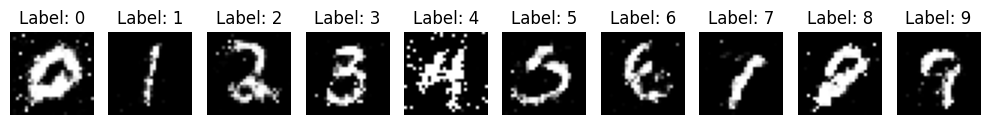

Generated images for each digit.


In [42]:
# Load the saved Generator weights
path2weights_gen = os.path.join(save_path, 'weights_gen.pt')
model_gen.load_state_dict(torch.load(path2weights_gen))

# Set the generator to evaluation mode
model_gen.eval()

# Generate images for each digit from 0 to 9
num_images_per_digit = 1 # You can change this to generate more images per digit
generated_images = []
generated_labels = []

with torch.no_grad(): # Disable gradient calculations
    for i in range(params['num_classes']):
        # Create noise and label tensors for the current digit
        noise = torch.randn(num_images_per_digit, params['nz']).to(device)
        labels = torch.full((num_images_per_digit,), i, dtype=torch.long).to(device)

        # Generate images
        fake_images = model_gen(noise, labels).cpu().detach()
        generated_images.append(fake_images)
        generated_labels.append(labels.cpu().detach())

# Concatenate the generated images and labels
generated_images = torch.cat(generated_images, dim=0)
generated_labels = torch.cat(generated_labels, dim=0)

# Display the generated images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=params['num_classes'], figsize=(10, 2))
for i, ax in enumerate(axes.flatten()):
    img = generated_images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {generated_labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Generated images for each digit.")